# Regressão em dados de NIRS (Near-Infrared Spectroscopy)

## Lidando com dados de alta dimensionalidade

Faremos a predição da quantidade de amido no milho através de dados de espectroscopia de infravermelho próximo.

Utilizaremos uma base de dados adaptada de [eigenvector](http://www.eigenvector.com/data/Corn/). A base conta com informações de 80 amostras de milho que foram medidas com 3 sensores NIRS entre as frequências de 1100-2498 nm, em intervalos de 2 nm. Assim, a base final conta com 2100 features, 80 amostras e 1 atributo preditivo, que no nosso caso, é a quantidade de amido.

Nesta prática veremos como mesmo algorítmos sofisticados de AM podem ter uma performance insatisfatória caso um bom pré-processamento não seja aplicado.

Iniciamos importando algumas bibliotecas úteis!

In [1]:
import numpy as np # Manipulação matricial, operações algébricas e estatísticas vetorizadas
import pandas as pd # Leitura de dados
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.preprocessing import StandardScaler # Normalização de dados

np.random.seed(0) # Seed de geração de números aleatórios para garantir reproducibilidade

### Leitura dos dados

In [2]:
data = pd.read_csv('data/starch_corn.csv')

### Shuffle dos dados (embaralhamento)
Uma boa prática para dados que não tem dependência temporal (ou não deveriam ter :P).

In [3]:
# Shuffle dataset
data = data.sample(frac=1)

print('Dimensões:', data.shape)
data.head()

Dimensões: (80, 2101)


,m5_wl1100nm,m5_wl1102nm,m5_wl1104nm,m5_wl1106nm,m5_wl1108nm,m5_wl1110nm,m5_wl1112nm,m5_wl1114nm,m5_wl1116nm,m5_wl1118nm,...,mp6_wl2482nm,mp6_wl2484nm,mp6_wl2486nm,mp6_wl2488nm,mp6_wl2490nm,mp6_wl2492nm,mp6_wl2494nm,mp6_wl2496nm,mp6_wl2498nm,starch
50,0.046298,0.046143,0.046014,0.045938,0.045929,0.045919,0.045973,0.046115,0.046358,0.046696,...,0.692214,0.693482,0.694446,0.695209,0.695613,0.695715,0.695498,0.695084,0.694521,64.915
27,0.053283,0.053084,0.053001,0.052958,0.052980,0.052963,0.053088,0.053320,0.053633,0.054047,...,0.777386,0.778539,0.779503,0.780110,0.780486,0.780510,0.780258,0.779764,0.779079,65.601
30,0.032143,0.032039,0.031920,0.031856,0.031851,0.031851,0.031935,0.032040,0.032261,0.032582,...,0.644735,0.645998,0.647045,0.647724,0.648107,0.648262,0.648119,0.647787,0.647291,64.420
77,0.049717,0.049573,0.049471,0.049391,0.049386,0.049382,0.049458,0.049639,0.049883,0.050283,...,0.692305,0.693519,0.694574,0.695208,0.695652,0.695707,0.695484,0.695075,0.694381,65.144
45,0.062052,0.061749,0.061598,0.061485,0.061281,0.061126,0.061176,0.061298,0.061361,0.061516,...,0.707183,0.708464,0.709389,0.710087,0.710465,0.710432,0.710324,0.709932,0.709275,65.519


Redefinindo os índices para garantir que o acesso aos dados ocorra como gostaríamos.

In [4]:
# Reset index
data = data.reset_index(drop=True)
data.head()

,m5_wl1100nm,m5_wl1102nm,m5_wl1104nm,m5_wl1106nm,m5_wl1108nm,m5_wl1110nm,m5_wl1112nm,m5_wl1114nm,m5_wl1116nm,m5_wl1118nm,...,mp6_wl2482nm,mp6_wl2484nm,mp6_wl2486nm,mp6_wl2488nm,mp6_wl2490nm,mp6_wl2492nm,mp6_wl2494nm,mp6_wl2496nm,mp6_wl2498nm,starch
0,0.046298,0.046143,0.046014,0.045938,0.045929,0.045919,0.045973,0.046115,0.046358,0.046696,...,0.692214,0.693482,0.694446,0.695209,0.695613,0.695715,0.695498,0.695084,0.694521,64.915
1,0.053283,0.053084,0.053001,0.052958,0.052980,0.052963,0.053088,0.053320,0.053633,0.054047,...,0.777386,0.778539,0.779503,0.780110,0.780486,0.780510,0.780258,0.779764,0.779079,65.601
2,0.032143,0.032039,0.031920,0.031856,0.031851,0.031851,0.031935,0.032040,0.032261,0.032582,...,0.644735,0.645998,0.647045,0.647724,0.648107,0.648262,0.648119,0.647787,0.647291,64.420
3,0.049717,0.049573,0.049471,0.049391,0.049386,0.049382,0.049458,0.049639,0.049883,0.050283,...,0.692305,0.693519,0.694574,0.695208,0.695652,0.695707,0.695484,0.695075,0.694381,65.144
4,0.062052,0.061749,0.061598,0.061485,0.061281,0.061126,0.061176,0.061298,0.061361,0.061516,...,0.707183,0.708464,0.709389,0.710087,0.710465,0.710432,0.710324,0.709932,0.709275,65.519


## Separação em porções de treino e teste, treinamento de modelo e avaliação

Aqui iremos fazer uma análise de performance muito simples. A ideia é separar o conjunto em porções de treino e teste. O teste nunca será utilizado para treinar o modelo, servindo apenas como indicativo de desempenho. Outras estratégia são preferíveis em situações reais para avaliação de desempenho, como por exemplo, a validação cruzada. No entanto, esse não é o nosso foco aqui. Passos a serem desenvolvidos:

- Separação do conjunto em porções de treino e teste (80/20)
- Definição de métricas de avaliação
- Treinamento de regressor
- Avaliação

Primeiramente, tomaremos 80% das amostras para treinamento do modelo.

In [5]:
threshold = int(round(0.8 * len(data)))
print('Utilizaremos {} amostras para treino!'.format(threshold))

Utilizaremos 64 amostras para treino!


### Partições de treino e teste

In [6]:
# Aqui estou transformando os DataFrames pandas para ndarrays
# do numpy, tanto por desempenho quanto por conveniência
tr = data.iloc[:threshold, :].values
ts = data.iloc[threshold:, :].values

print('Dimensões treino:', tr.shape)
print('Dimensões teste:', ts.shape)

Dimensões treino: (64, 2101)
Dimensões teste: (16, 2101)


Separação das features de treinamento e o atributo alvo.

In [7]:
X_tr, y_tr = tr[:, :-1], tr[:, -1]
X_ts, y_ts = ts[:, :-1], ts[:, -1]

### Antes de continuar...

Como iremos avaliar nosso futuro regressor? Nos dados de teste, certo? Mas e com que métricas de avaliação? Será que algumas são mais adequadas do que as outras dependendo do contexto?

Avaliaremos duas possibilidades:
- Root Mean Square Error (RMSE)
- Relative Root Mean Square Error (RRMSE)

#### RMSE

Mede a raiz do desvio quadrático da previsão ($\hat{y}$) para os valores esperados ($y$). Os valores resultantes estão na mesma escala do que o atributo alvo.

\begin{equation*}
    \text{RMSE} = \sqrt{\frac{\sum_{i}^{n}(y_i - \hat{y}_i)^2}{n}}
\end{equation*}

#### RRMSE 

Compara o RMSE do preditor contra um baseline (que é a média da variável alvo). Não possui escala, mas permite interpretações interessantes. Por exemplo, um $\text{RRMSE} \ge 1$ implica que o regressor é pior ou tão ruim quanto o baseline (sempre "chutar" na média).

\begin{equation*}
    \text{RRMSE} = \sqrt{\frac{\sum_{i}^{n}(y_i - \hat{y}_i)^2}{\sum_{i}^{n} (y_i - \overline{y})^2}}
\end{equation*}

Implementações:

In [8]:
def RMSE(obs, pred):
    return np.sqrt(np.sum((obs - pred) ** 2) / len(obs))

def RRMSE(obs, pred):
    # Adicionamos uma pequena constante (10^{-6}) no numerador e denominador
    # para evitar possíveis divisões por zero
    num = np.sum((obs - pred) ** 2) + 1e-6
    den = np.sum((obs - np.mean(obs)) ** 2) + 1e-6
    
    return np.sqrt(num / den)

### Agora voltamos à criação do nosso regressor =)

Alguns fatos interessantes sobre a Random Forest (RF) e porque está é a minha técnica de escolha em grande parte dos casos:

- Ensemble
- Robusta a ruídos e outliers
- Pouco sensível a parametrização (na prática, sempre "ready to go")
- Inerentemente paralelizável
- Uma das técnicas mais acuradas atualmente

Antes de treinar a RF aplicaremos uma normalização aos dados (z-score). "Centering" pela média e "scaling" pelo desvio padrão $\rightarrow$ dados com média zero e desvio padrão unitário. Não é mandatório para todos os métodos, mas geralmente recomendado.

\begin{equation*}
    z_i = \frac{x_i - \overline{x}}{\sigma_x}
\end{equation*}


### Normalizando dados e treinando uma RF:

In [9]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_tr = scaler_x.fit_transform(X_tr)
y_tr = scaler_y.fit_transform(y_tr.reshape(-1, 1))[:, 0]

rf = RandomForestRegressor(n_estimators=100, max_features='sqrt')
rf.fit(X_tr, y_tr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Avaliando o modelo treinado

Aqui, **aplicamos** a mesma estratégia de normalização nos dados de teste antes de submetê-los ao modelo treinado.

In [10]:
X_ts = scaler_x.transform(X_ts)
predictions_orig = rf.predict(X_ts)
predictions_orig = scaler_y.inverse_transform(predictions_orig.reshape(-1, 1))[:, 0]

In [11]:
predictions_orig

array([64.62761, 64.40568, 64.14535, 64.94335, 64.84522, 65.51178,
       65.1368 , 64.6869 , 64.8177 , 64.76613, 64.95292, 65.44127,
       65.00354, 65.37264, 64.89976, 64.26278])

E calculamos os erros obtidos:


#### RMSE

In [12]:
print('RMSE:', RMSE(y_ts, predictions_orig))

RMSE: 1.0386447864796


Será que estamos indo bem? Que tal olhar os ranges?

In [13]:
print('Range dos dados de treinamento:', max(y_tr) - min(y_tr))
print('Range dos dados de teste:', max(y_ts) - min(y_ts))

Range dos dados de treinamento: 4.73246234746976
Range dos dados de teste: 2.9110000000000085


Parece que o erro aparentemente baixo não foi tão baixo assim.

Agora iremos avaliar o nosso modelo na presença de um baseline:

#### RRMSE

In [14]:
print('RRMSE:', RRMSE(y_ts, predictions_orig))

RRMSE: 1.0997998117346433


### Conclusão:

~~Teria sido melhor ir assistir o filme do Pelé.~~ Teria sido melhor sempre chutar a média do conjunto de teste. :/

Mas e agora? O que fazer? Por que um modelo dito robusto e acurado se saiu tão mal?

O que estamos deixando passar?

#### Hipóteses:

- ~~Problema de um milhão de dólares!~~ (pouco provável)
- ~~Bug do sklearn~~ (pode acontecer, mas pouco provável nesse caso)
- ~~Problema na pecinha atrás do computador~~ (acontece com bastante frequência, mas não é o caso dessa vez)
- Dados? Poucas amostras para treinamento? $\rightarrow$ pode ser um caminho...
- Forma como tratamos os dados $\rightarrow$ pré-processamento?
    * Muito provável!


Vamos voltar ao princípio, analisando os dados:

In [15]:
# Dimensões dos dados de treinamento
tr.shape

(64, 2101)

### Algo estranho?

Sim!!! Temos muito mais descritores do que amostras. Uma alternativa pode ser utilizar um extrator de features, já que nesse contexto estamos mais interessados em predizer a propriedade do que interpretar os atributos que estamos utilizando para tal tarefa.

Utilizaremos a Principal Component Analysis ([PCA](https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2)) para esse fim!

(peço desculpas pela más prática de programação a seguir -- importando novos pacotes)

In [16]:
import matplotlib.pyplot as plt # Biblioteca para a construção de gráficos
from sklearn.decomposition import PCA

In [17]:
# Definindo novos conjuntos de treinamento
X_tr_pca = tr[:, :-1]
X_ts_pca = ts[:, :-1]

scaler_x_pca = StandardScaler()
X_tr_pca = scaler_x_pca.fit_transform(X_tr_pca)
X_ts_pca = scaler_x_pca.transform(X_ts_pca)

### Vamos fazer alguns testes com a PCA

In [18]:
# Começamos chutando alto => n_components == número de amostras (máximo permitido pelo sklearn)
pca = PCA()
pca.fit(X_tr_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Antes de utilizarmos tantos componentes, que tal avaliarmos a **variância dos dados** que cada um deles explica (em %)?

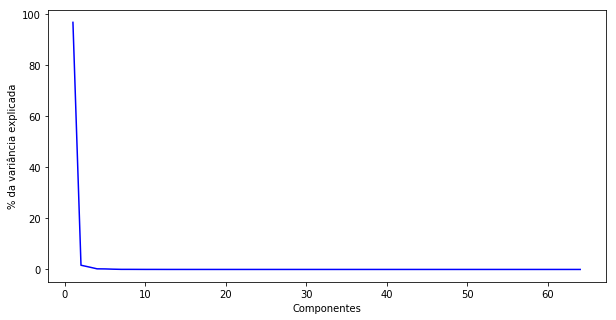

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([i + 1 for i in range(len(pca.explained_variance_ratio_))], 100 * pca.explained_variance_ratio_, 'b-')
ax.set_xlabel('Componentes')
ax.set_ylabel('% da variância explicada')
pass

#### Parece haver uma queda vertiginosa! Vamos explorar do ponto de vista cumulativo.

Primeiros elementos [96.71311686 98.36254659 99.32135205 99.56146196 99.76429908 99.86628713
 99.90018263 99.93236289 99.95569175 99.96827882 99.97993207 99.98720371
 99.99008989 99.99256241 99.99399365 99.995182   99.99602121 99.99670565
 99.99723513 99.99762539]


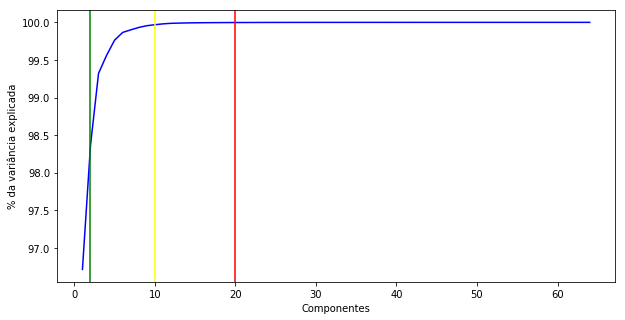

In [20]:
print('Primeiros elementos', (100 * pca.explained_variance_ratio_.cumsum())[:20])
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([i + 1 for i in range(len(pca.explained_variance_ratio_))], 100 * pca.explained_variance_ratio_.cumsum(), 'b-')
ax.axvline(2, color='green')
ax.axvline(10, color='yellow')
ax.axvline(20, color='red')
ax.set_xlabel('Componentes')
ax.set_ylabel('% da variância explicada')
pass

### Vamos tentar utilizar menos componentes?

Normalmente, buscamos a quantidade de componentes que explicam entre 95-99% da variância dos dados (experiência própria). O restante normalmente está capturando variações de ruído ou outros aspectos que não nos interessam. Nesse caso empíricamente escolhi os 10 primeiros componentes (um pouco exagerado até, talvez). Os resultados foram bem melhores para a RF. Decidi adicionar um modelo linear e aumentar para 15 e depois 20 componentes. Os resultados surpreenderam. 

Sugiro testarem outros valores e avaliarem os resultados obtidos.


In [21]:
pca = PCA(n_components=20)

X_tr_pca = pca.fit_transform(X_tr_pca)
X_ts_pca = pca.transform(X_ts_pca)

In [22]:
X_tr_pca.shape

(64, 20)

#### Voltando à RF

In [23]:
rf_pca = RandomForestRegressor(n_estimators=100, max_features='sqrt')
rf_pca.fit(X_tr_pca, y_tr)
preds_rf = rf_pca.predict(X_ts_pca)
preds_rf = scaler_y.inverse_transform(preds_rf.reshape(-1, 1))[:, 0]

print('RMSE da RF:', RMSE(y_ts, preds_rf))
print('RRMSE da RF:', RRMSE(y_ts, preds_rf))

RMSE da RF: 0.7940860185064962
RRMSE da RF: 0.8408415302375901


#### "Avacalhation" time

Vamos treinar uma simples regressão linear

In [24]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_tr_pca, y_tr)

preds_lr = lr.predict(X_ts_pca)
preds_lr = scaler_y.inverse_transform(preds_lr.reshape(-1, 1))[:, 0]
print('RMSE da LR:', RMSE(y_ts, preds_lr))
print('RRMSE da LR:', RRMSE(y_ts, preds_lr))

RMSE da LR: 0.37561718778662084
RRMSE da LR: 0.3977334670353131


In [25]:
lr.coef_

array([ 1.36556543e-03, -1.44606694e-02,  2.40548681e-02, -7.01287594e-02,
        1.79961690e-01, -1.15146765e-02, -3.59760056e-01, -2.51777122e-02,
        6.03110953e-01,  5.12555987e-01,  3.48266724e-01, -1.07716796e+00,
       -1.69779494e-01, -1.16358920e+00, -9.46779747e-01,  4.63364883e-01,
        1.52624549e+00,  2.57815909e-01, -8.25913421e-01,  1.96810721e+00])

# Considerações finais

Um modelo linear se saiu melhor do que um ensemble!
- Canhão vs. mosca.
- Pequena quantidade de amostras de treinamento.
- Problema linear! $\rightarrow$ viés de aprendizado do algoritmo não adequado ao problema, dadas as características do dataset.
    * Como traçar uma reta usando retângulos? :D

A utilização de pré-processamento com PCA foi essencial para diminuir o erro preditivo!
- Os modelos finais conseguiram melhor e muito o desempenho do baseline
    * Importância da utilização de métricas adequadas para avaliação.